In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import lib.preprocess.envelope
import matplotlib.colors

In [2]:
data_dir = 'datasets/RetrospectivePatients/id001_bt'
results_dir = 'results/exp10/exp10.23'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

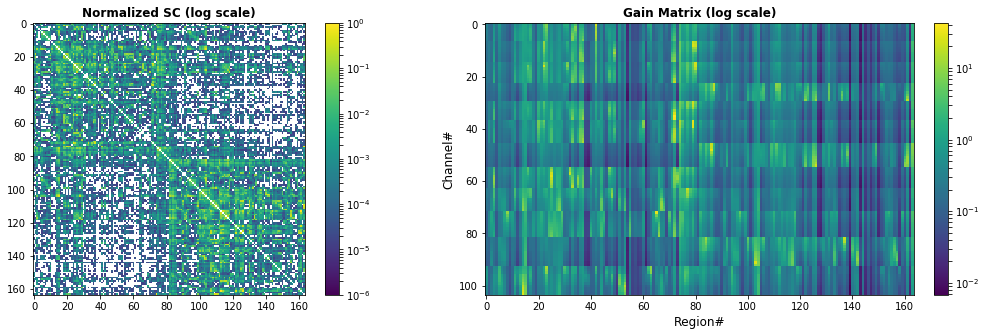

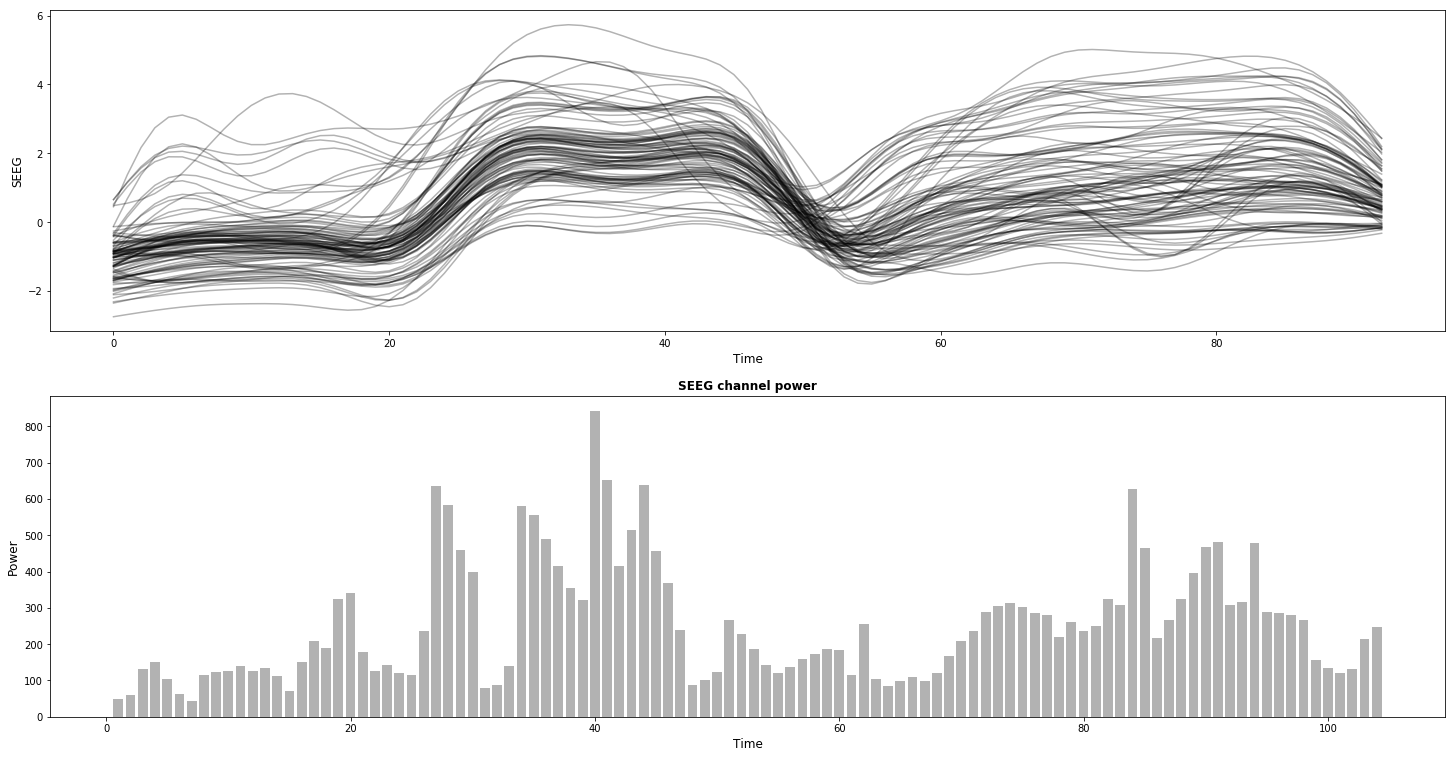

In [3]:
SC = np.loadtxt(f'{data_dir}/tvb/connectivity_des/weights.txt')
SC[np.diag_indices(SC.shape[0])] = 0
SC = SC/SC.max()

data = lib.io.stan.rload(f'{data_dir}/vep/data.R')
szr_onset_idxs = np.where(data['is_first'] ==1)[0]
seeg = data['seeg'][:,szr_onset_idxs[0]:szr_onset_idxs[1]].T
gain = data['gain']

slp = lib.preprocess.envelope.bfilt(seeg, 256, 0.5, 'highpass', axis=0)
slp = lib.preprocess.envelope.bfilt(slp, 256, 20, 'lowpass', axis=0)
snsr_pwr = np.sum(slp**2, axis=0)


plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(SC,norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=SC.max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(gain,norm=matplotlib.colors.LogNorm(vmin=gain.min(), vmax=gain.max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(slp, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SEEG', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],snsr_pwr, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target.png')
# plt.tight_layout()


In [4]:
nn = data['nn']
ns = data['ns']
nt = slp.shape[0]
I1 = 3.1
# tau0=30
# time_step=0.1

stan_fname = 'vep-snsrfit-ode'

x0_star = np.zeros(nn)
x_init_star = np.zeros(nn)
z_init_star = np.zeros(nn)
amplitude_star = 0.0
offset = 0.0
time_step_star = 0.0
K_star = 0.0
tau0_star = 0.0

param_init = {'x0_star':x0_star, 'x_init_star':x_init_star, 'z_init_star':z_init_star,
              'amplitude_star':amplitude_star, 'offset':offset, 'time_step_star':time_step_star,
              'K_star':K_star, 'tau0_star':tau0_star}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

epsilon_snsr_pwr = 5.0
for epsilon_slp in np.array([0.1]):
    fname_suffix = f'epsslp{epsilon_slp:0.5f}_epssnsrpwr_{epsilon_snsr_pwr:0.5f}'
    data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'SC':SC, 'gain': gain,
            'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr,
            'slp':slp, 'snsr_pwr':snsr_pwr}
    input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
    os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
    lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)
#     nchains = 4
#     with open('vep-snsrfit-ode.sh','r') as fd:
#         slurm_script = fd.read().format(f'{results_dir}/Rfiles', results_dir, input_Rfile, nchains, eps)
#     with open(f'tmp/vep-snsrfit-ode-eps{eps:0.1f}.sh','w') as fd:
#         fd.write(slurm_script)
#     lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-ode-eps{eps:0.1f}.sh'],block=False)

# data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'time_step':time_step, 'nsteps':nsteps,
#         'tau0':2857.0, 'SC':SC, 'K':K, 'gain': gain_mat, 'epsilon':epsilon, 
#         'slp':syn_data['fit_trgt']}
# input_Rfile = f'fit_data_snsrfit_ode_epsilon{epsilon:0.5f}.R'
# os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
# lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

# ! srun -p dev --ntasks=1 {stan_fname} sample save_warmup=1 num_warmup=200 num_samples=200 \
# adapt delta=0.8 algorithm=hmc engine=nuts max_depth=10 data file={results_dir}/Rfiles/{input_Rfile} \
# init=0 output file={results_dir}/samples_epsinfer_chain1.csv refresh=5


# cmd = f'./{stan_fname} variational algorithm=meanfield iter=100000 tol_rel_obj=0.01 \
# output_samples=1000 data file={results_dir}/Rfiles/{input_Rfile} \
# init={results_dir}/Rfiles/param_init.R \
# output file={results_dir}/samples_epsilon{epsilon:0.5f}.csv'
# print(cmd.split(' '))
# lib.io.stan.create_process(cmd.split(' '), block=True)



In [ ]:
%%bash -s "$stan_fname"
stancompile.sh $1

In [ ]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
for i in {1..4};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=200 num_warmup=200 \
save_warmup=1 adapt delta=0.8 algorithm=hmc engine=nuts max_depth=10 \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987324514*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
# ./${STAN_FNAME}  id=$((100*${i})) variational iter=1000000 tol_rel_obj=0.01 \
# elbo_samples=1000 output_samples=1000 data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
# output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv \
# &> ${RESULTS_DIR}/logs/snsrfit_cntr_${FNAME_SUFFIX}_chain${i}.log &
done

In [5]:
# import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

# csv_fname = 'results/exp10/exp10.4/samples_epsinfer_chain1.csv'
# nwarmup = 200
# nsampling = 100
# ignore_warmup = True
# variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
#                          'divergent__', 'energy__','x0',  'x', 'mu_seeg', 'amplitude', 'offset',\
#                          'x_init', 'z_init', 'epsilon']
# pstr_samples_1 = lib.io.stan.read_samples(csv_fname) # read sampler diagnostics and x0 for all sampling iterations
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in [2,3,4]]) # read sampler diagnostics and x0 for all sampling iterations

# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

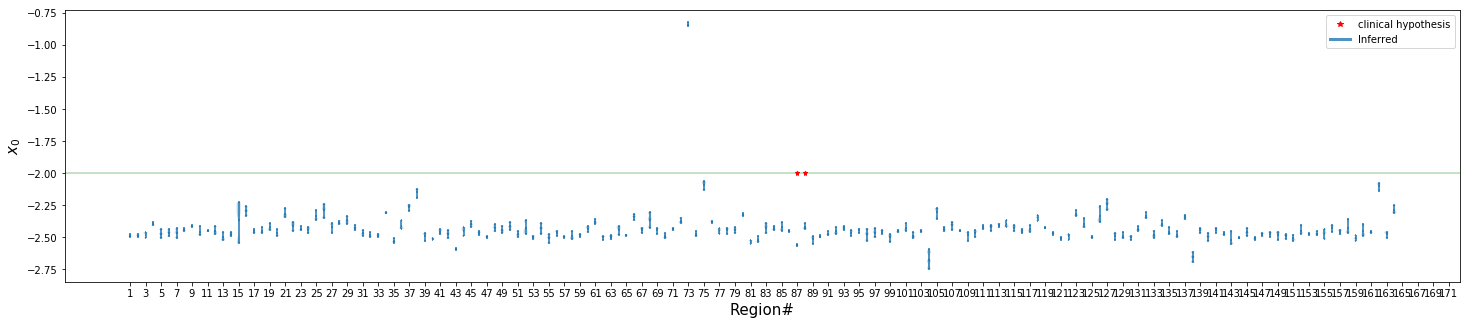

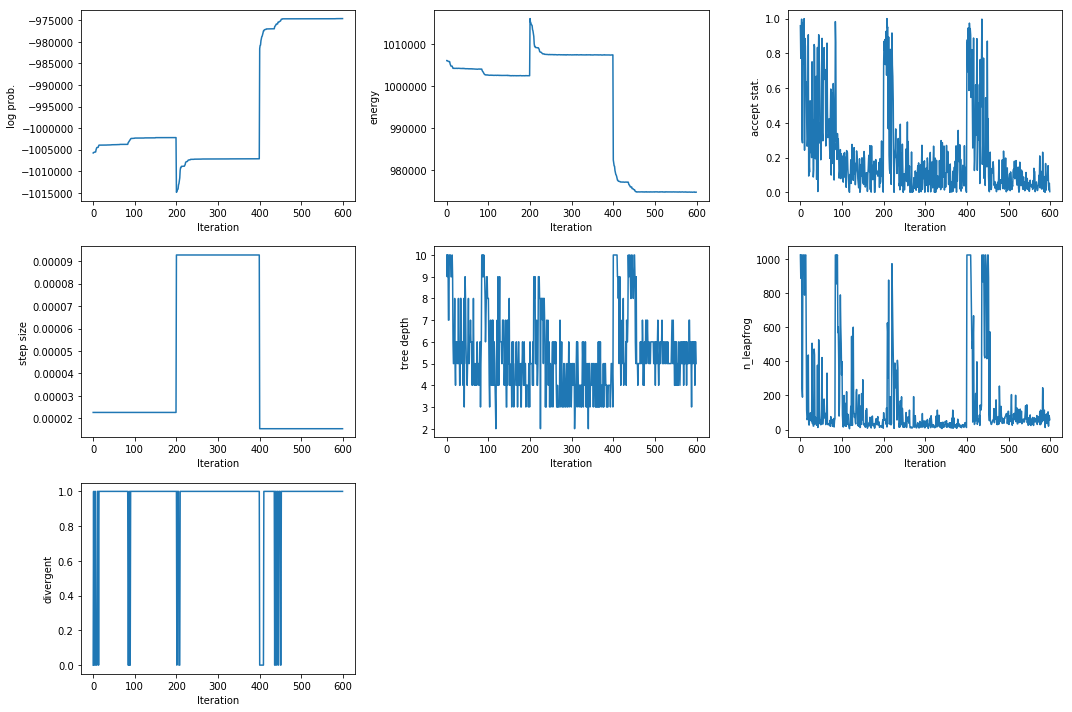

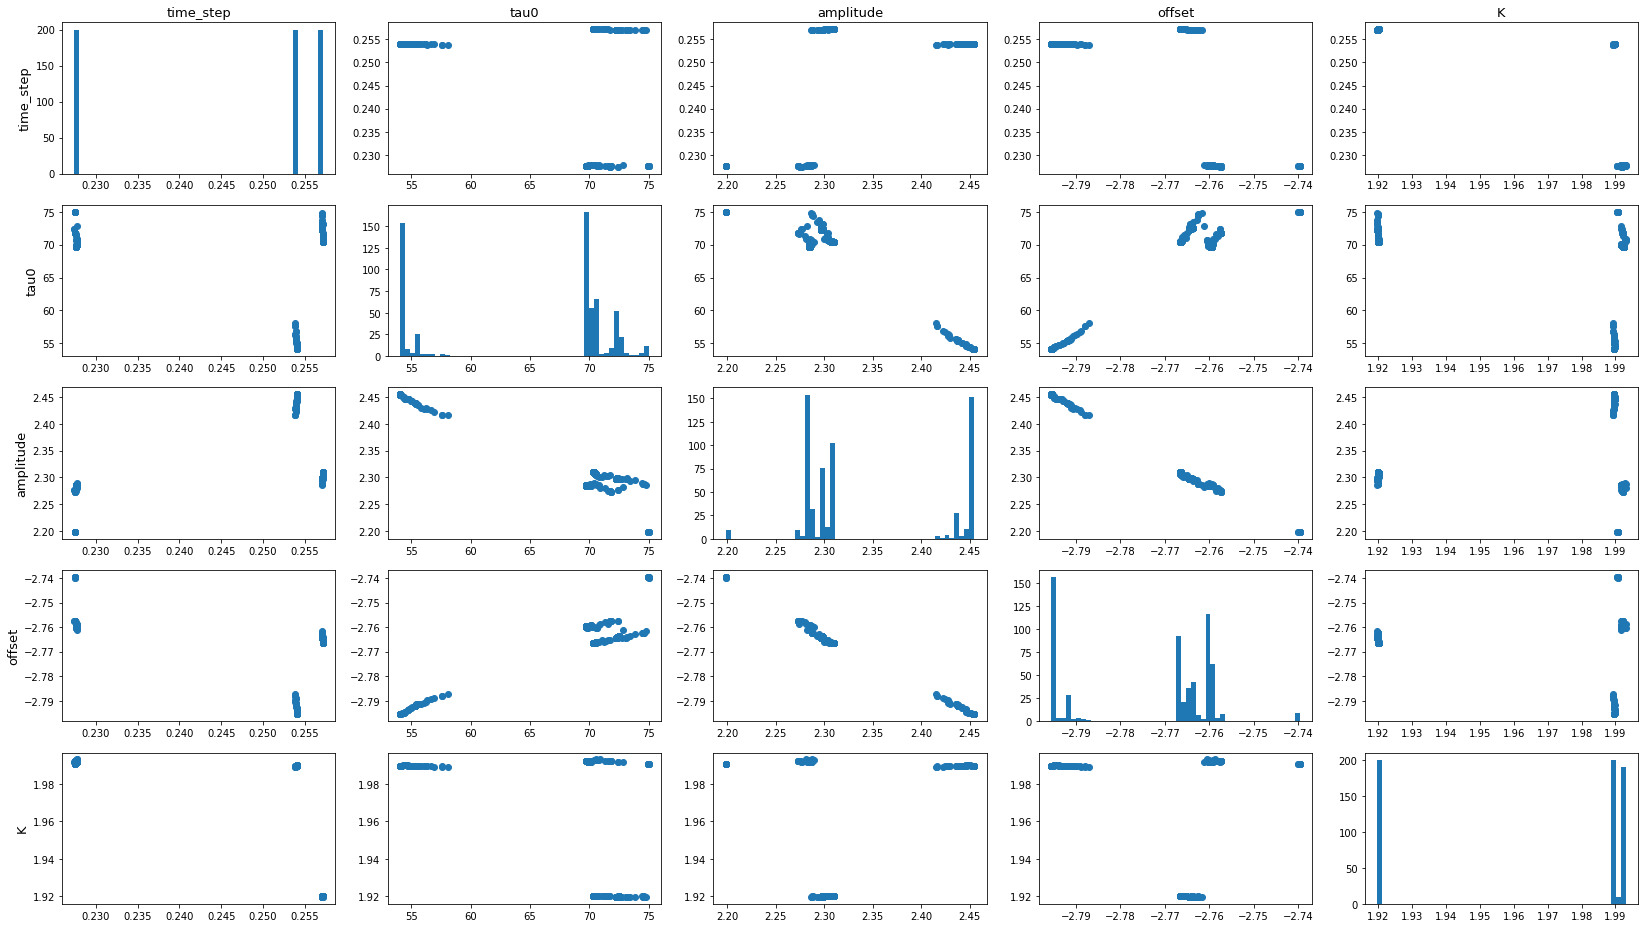

In [6]:
import importlib
importlib.reload(lib.plots.stan)

ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0] + 1

lib.plots.stan.x0_violin_patient(pstr_samples_1['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
# plt.figure(figsize=(25,5))
# plt.violinplot(pstr_samples_1['x0'], showmeans=True, points=1000);
# plt.title('Distribution of inferred x0', fontsize=13, fontweight='bold')
# plt.xticks(np.r_[1:nn+1:2], np.r_[1:nn+1:2])
# plt.xlabel('Region#')

lib.plots.stan.nuts_diagnostics(pstr_samples_1, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')

plt.figure(figsize=(23,13))
params = ['time_step', 'tau0', 'amplitude', 'offset', 'K']
nParams = len(params)
for i in range(nParams):
    for j in range(nParams):
        plt.subplot(nParams, nParams, i * nParams + (j + 1))
        if(i == j):
            plt.hist(pstr_samples_1[params[i]].flatten(), bins=50)
        else:
            xvals = np.mean(pstr_samples_1[params[j]], axis=1) if len(pstr_samples_1[params[j]].shape)>1 else pstr_samples_1[params[j]]
            yvals = np.mean(pstr_samples_1[params[i]], axis=1) if len(pstr_samples_1[params[i]].shape)>1 else pstr_samples_1[params[i]]
            plt.plot(xvals, yvals, 'o')
        if(i == 0):
            plt.title(params[j], fontsize=13)
        if(j == 0):
            plt.ylabel(params[i], fontsize=13, rotation=90)
plt.tight_layout()
# plt.savefig(f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')

# # Mean and 2*std of source activity(x) estimated from posterior samples
# plt.figure(figsize=(15,20))
# x_mean = np.mean(pstr_samples_1['x'], axis = 0)
# x_std = np.std(pstr_samples_1['x'], axis = 0)
# nt = x_mean.shape[0]
# nn = x_mean.shape[1]
# for i in range(nn):
#     plt.plot(x_mean[:,i]+4*i)
#     plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
# plt.title('source activity(x)',fontsize=15);
# plt.xlabel('time',fontsize=15);
# plt.ylabel('Region#',fontsize=15);
# plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);

Simulation of 2D epileptor at posterior mean

In [25]:
tau0_mean = np.mean(pstr_samples_1['tau0'])
x0_mean = np.mean(pstr_samples_1['x0'], axis=0)
x_init_mean = np.mean(pstr_samples_1['x_init'], axis=0)
z_init_mean = np.mean(pstr_samples_1['z_init'], axis=0)
time_step_mean = np.mean(pstr_samples_1['time_step'])
amplitude_mean = np.mean(pstr_samples_1['amplitude'])
offset_mean = np.mean(pstr_samples_1['offset'])
K_mean = np.mean(pstr_samples_1['K'])
print(x0_mean, x_init_mean, z_init_mean, time_step_mean, tau0_mean, amplitude_mean, offset_mean, K_mean)

[-2.48792443 -2.48633027 -2.47798857 -2.39747798 -2.47017487 -2.4638239
 -2.46595575 -2.44240635 -2.41331467 -2.45757997 -2.44853618 -2.44893543
 -2.4980571  -2.47437642 -2.36198997 -2.2943375  -2.45312435 -2.44986703
 -2.4232411  -2.46953123 -2.31481418 -2.41030228 -2.43205178 -2.43960313
 -2.33621527 -2.28868732 -2.41738868 -2.38617688 -2.36855923 -2.42391667
 -2.46744767 -2.48336508 -2.48417197 -2.30759345 -2.52678305 -2.4090076
 -2.26427165 -2.14648633 -2.49001518 -2.50972812 -2.45447078 -2.47395607
 -2.58844693 -2.45052648 -2.39619062 -2.4649249  -2.49632447 -2.42500548
 -2.43977477 -2.41359023 -2.47672117 -2.42842518 -2.49998035 -2.42951808
 -2.50758592 -2.46360978 -2.4953014  -2.48852448 -2.48220147 -2.43302817
 -2.37675797 -2.50049635 -2.49786743 -2.44108453 -2.48476285 -2.34105767
 -2.44057217 -2.36189818 -2.44366383 -2.49109457 -2.43513627 -2.37245752
 -0.84505759 -2.47353823 -2.09150372 -2.37693793 -2.44808972 -2.44531217
 -2.44294718 -2.3263451  -2.53315565 -2.51832233 -2.4

In [26]:
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0_mean, 'gain':gain, 'SC':SC, \
        'K':K_mean, 'x0':x0_mean, 'x_init':x_init_mean, 'z_init':z_init_mean, \
        'time_step':time_step_mean, 'amplitude': amplitude_mean, 'offset':offset_mean}
lib.io.stan.rdump(f'{results_dir}/Rfiles/posterior_simulation_data_{fname_suffix}.R', data)

In [27]:
%%bash
stancompile.sh vep-forwardsim-2Depileptor-ode-nointerp

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-forwardsim-2Depileptor-ode-nointerp' is up to date.


In [28]:
%%bash -s "$results_dir" "$fname_suffix"
./vep-forwardsim-2Depileptor-ode-nointerp sample num_warmup=0 num_samples=1 algorithm=fixed_param \
data file=$1/Rfiles/posterior_simulation_data_${2}.R output file=$1/posterior_simulation_${2}.csv

method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp10/exp10.23/Rfiles/posterior_simulation_data_epsslp0.10000_epssnsrpwr_5.00000.R
init = 2 (Default)
random
  seed = 3394614345
output
  file = results/exp10/exp10.23/posterior_simulation_epsslp0.10000_epssnsrpwr_5.00000.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.035436 seconds (Sampling)
               0.035436 seconds (Total)



In [29]:
sim_data = lib.io.stan.read_samples([f'{results_dir}/posterior_simulation_{fname_suffix}.csv'])
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]

# x_syn = syn_data['src_sig'][2500:4000,0,:,0] + syn_data['src_sig'][2500:4000,3,:,0]
# ez = syn_data['ez']
# pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

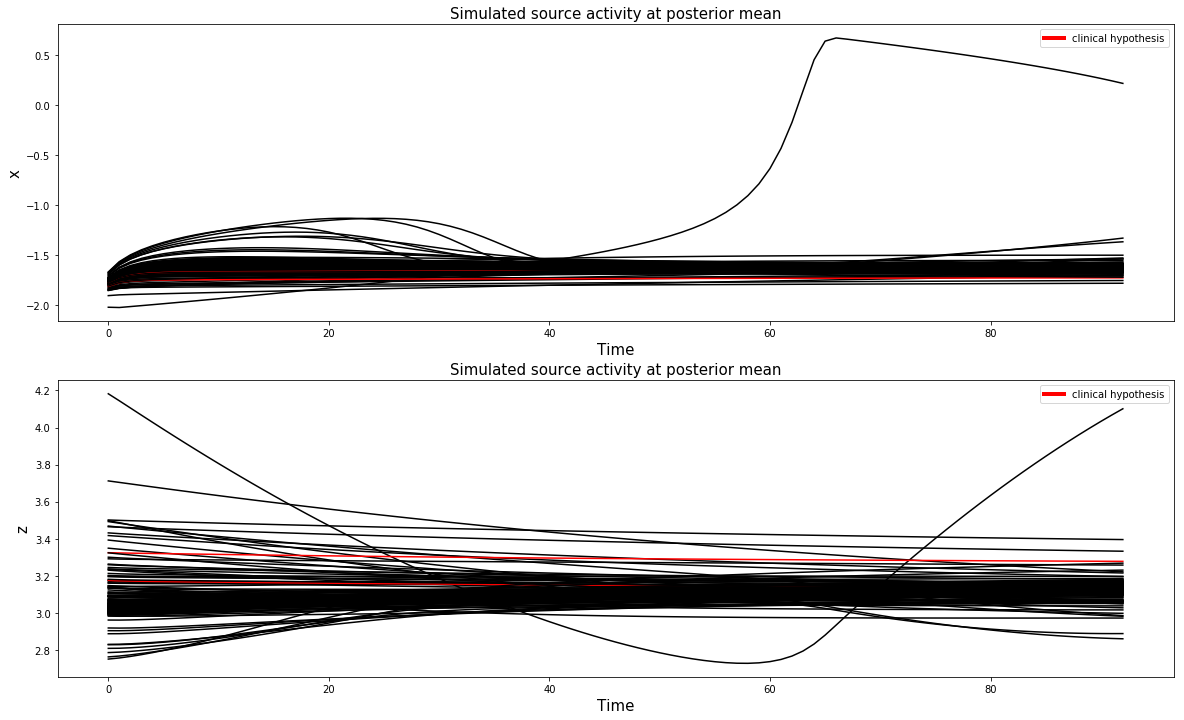

In [30]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]

plt.figure(figsize=(20,12))
plt.subplot(211)
legend_elements = [Line2D([0], [0], color='red', linewidth=4, label='clinical hypothesis')]

for i in range(nn):
    if(i in ez_hyp):
        plt.plot(x_sim[:,i], color='red');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Simulated source activity at posterior mean', fontsize=15)
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/simulated_src_x_at_posterior_mean_1.png')

plt.subplot(212)
for i in range(nn):
    if(i in ez_hyp):
        plt.plot(z_sim[:,i], color='red');
    else:
        plt.plot(z_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Simulated source activity at posterior mean', fontsize=15)
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/simulated_src_z_at_posterior_mean_1.png')

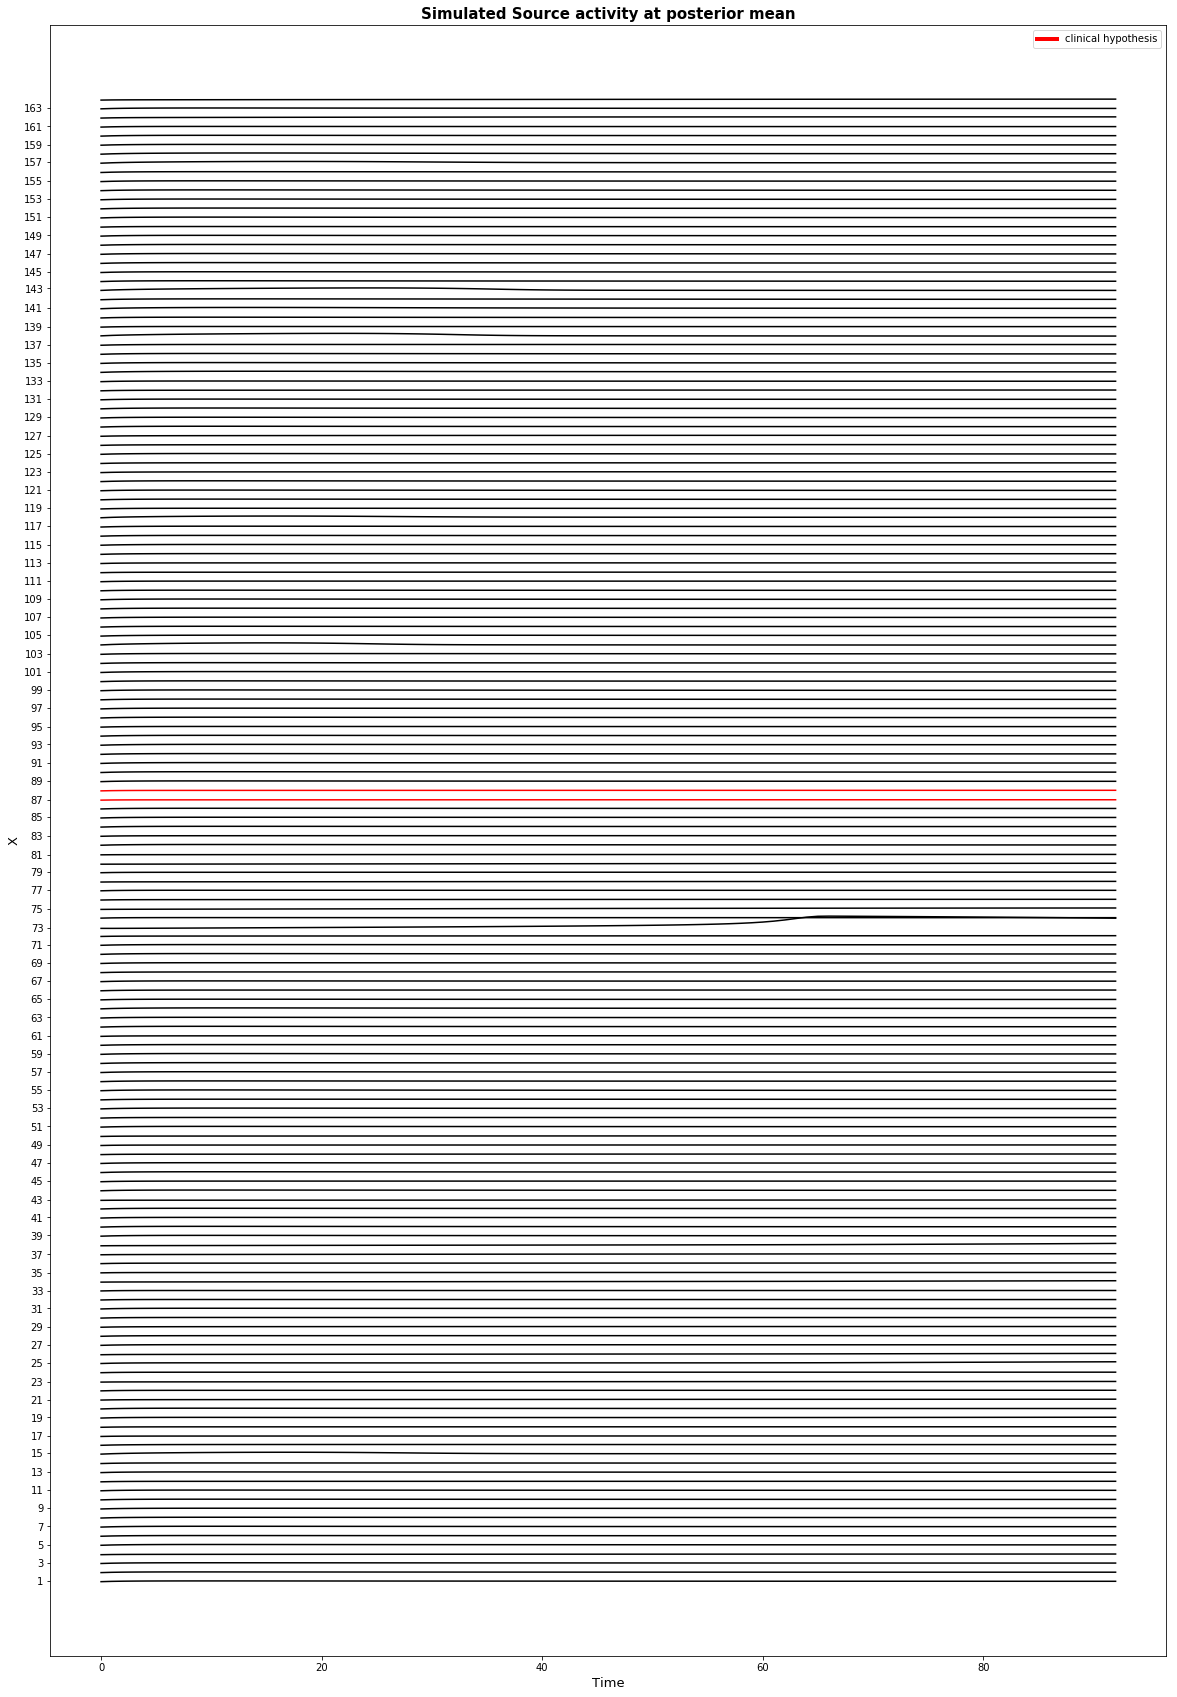

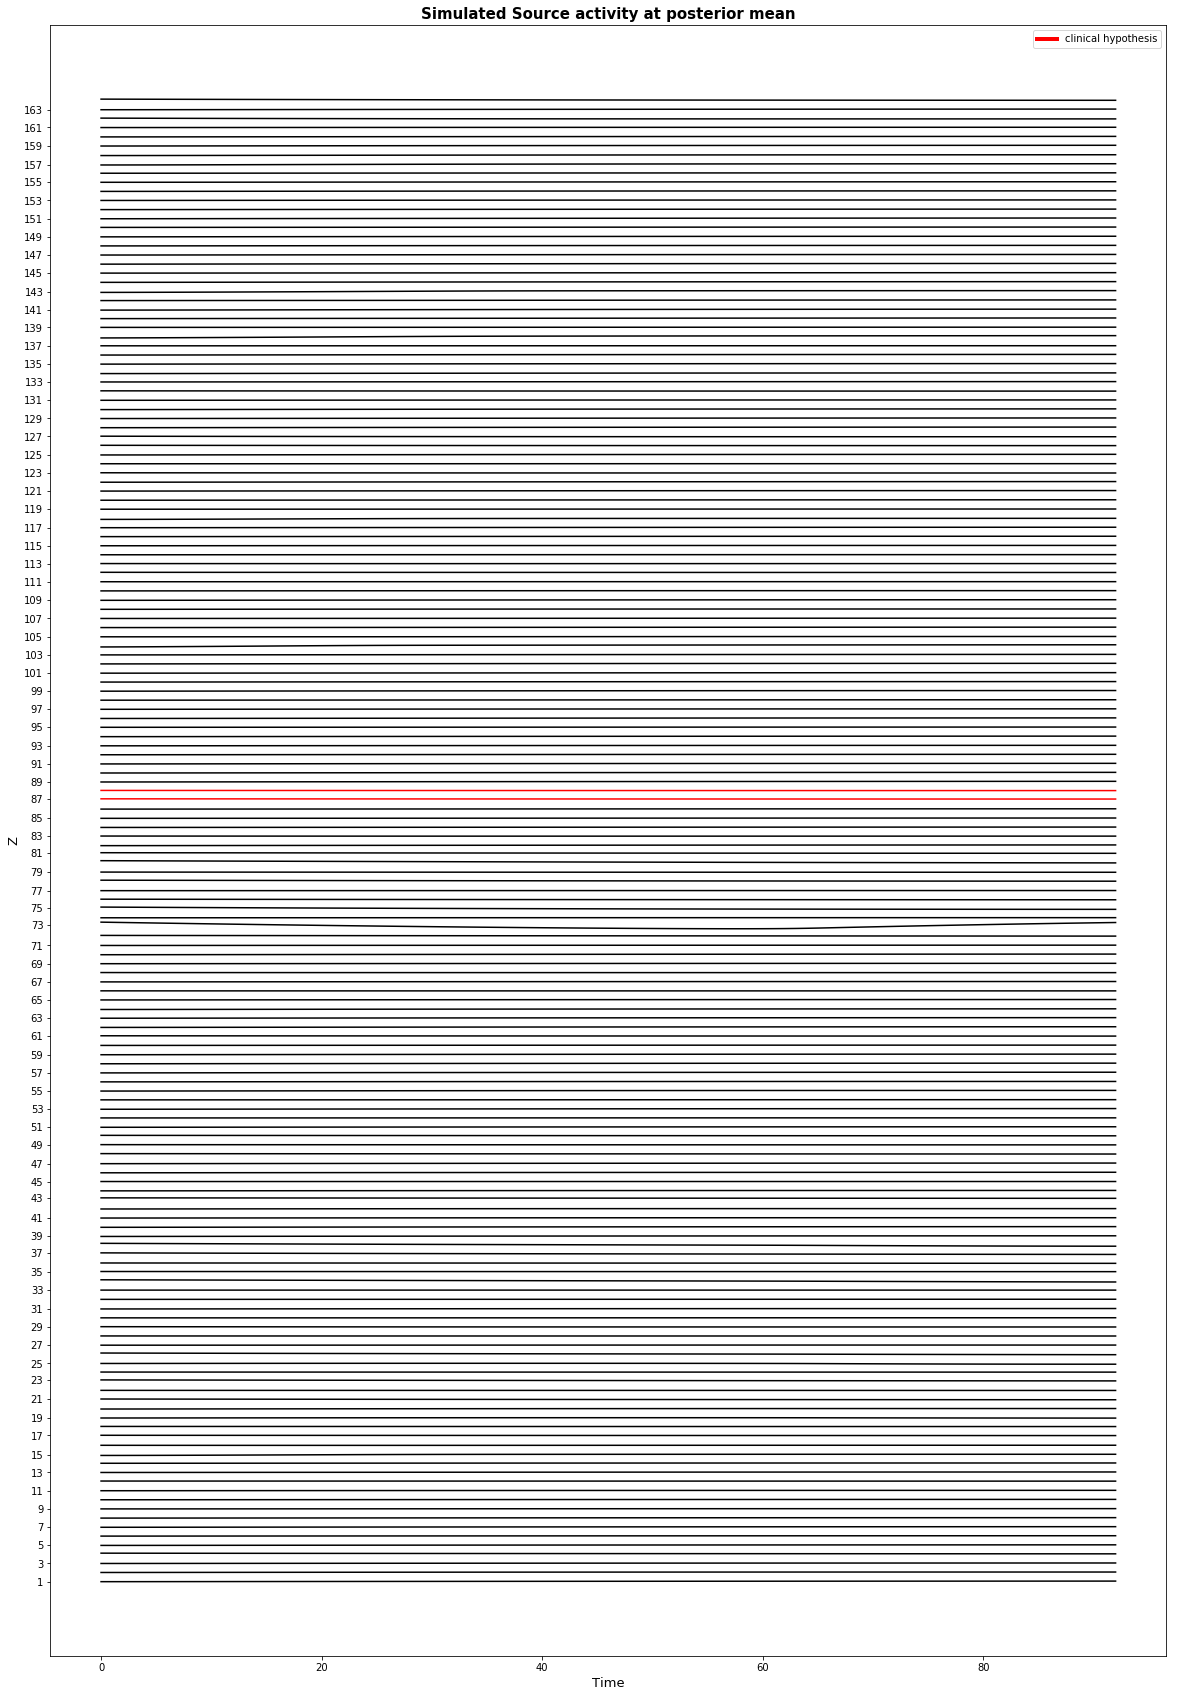

In [31]:
plt.figure(figsize=(20,30))
for i in range(nn):
    if(i in ez_hyp):
        plt.plot(x_sim[:,i] + 2*i,'r');
    else:
        plt.plot(x_sim[:,i] + 2*i,'k');
plt.xlabel('Time', fontsize=13)
plt.ylabel('X', fontsize=13)
plt.yticks(np.mean(x_sim[1:30,:] + 2*np.r_[0:nn], axis=0)[0:-1:2], np.r_[1:nn+1:2]);
legend_elements = [Line2D([0], [0], color='red', linewidth=4, label='clinical hypothesis')]
plt.legend(handles=legend_elements)
plt.title('Simulated Source activity at posterior mean', fontsize=15, fontweight='bold')
plt.savefig(f'{results_dir}/figures/simulated_src_x_at_posterior_mean_2.png')

plt.figure(figsize=(20,30))
for i in range(nn):
    if(i in ez_hyp):
        plt.plot(z_sim[:,i] + 2*i,'r');
    else:
        plt.plot(z_sim[:,i] + 2*i,'k');
plt.xlabel('Time', fontsize=13)
plt.ylabel('Z', fontsize=13)
plt.yticks(np.mean(z_sim[1:30,:] + 2*np.r_[0:nn], axis=0)[0:-1:2], np.r_[1:nn+1:2]);
legend_elements = [Line2D([0], [0], color='red', linewidth=4, label='clinical hypothesis')]
plt.legend(handles=legend_elements)
plt.title('Simulated Source activity at posterior mean', fontsize=15, fontweight='bold')
plt.savefig(f'{results_dir}/figures/simulated_src_z_at_posterior_mean_2.png')

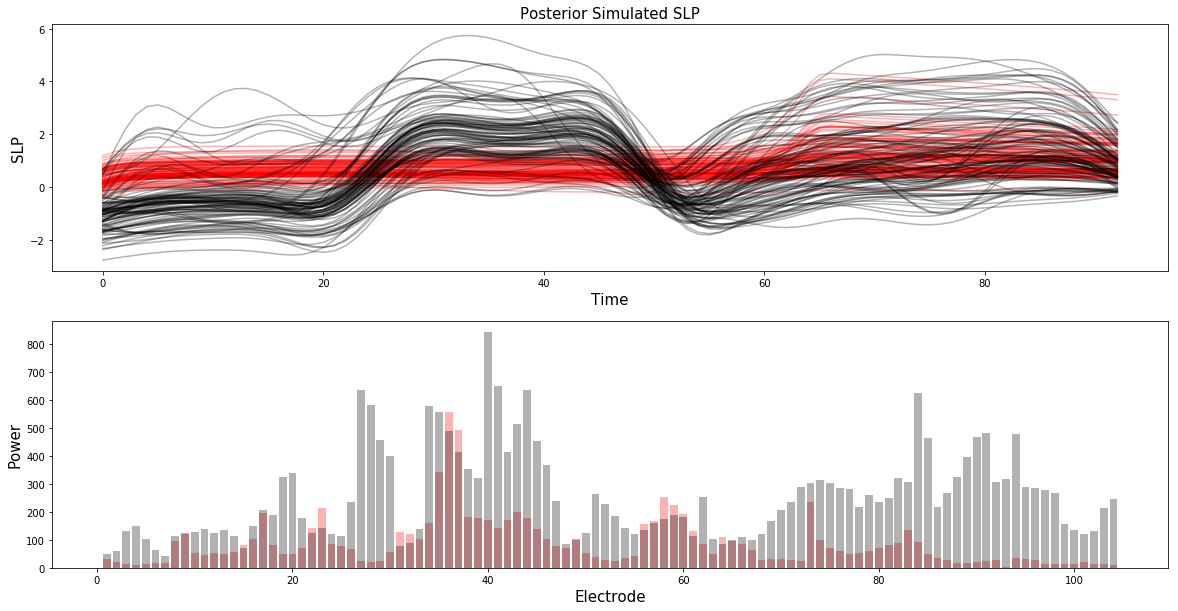

In [32]:
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
slp = sim_data['slp'][0]
snsr_pwr = sim_data['snsr_pwr'][0]

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(slp, color='red', alpha=0.3);
plt.plot(fit_data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior Simulated SLP', fontsize=15)

plt.subplot(212)
plt.bar(np.arange(1,ns+1), snsr_pwr, color='red', alpha=0.3);
plt.bar(np.arange(1,ns+1), fit_data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulated_slp_{fname_suffix}.png')

